In [2]:
!kaggle competitions download -f train.csv.zip --path ./data
!kaggle competitions download -f test.csv.zip --path ./data

Using competition: avito-demand-prediction
train.csv.zip: Downloaded 308MB of 308MB to ./data
Using competition: avito-demand-prediction
test.csv.zip: Downloaded 107MB of 107MB to ./data


In [3]:
import pandas as pd
import numpy as np
import os
import dotenv
import matplotlib.pyplot as plt

dotenv.load_dotenv('.env')

True

In [0]:
types = ['train', 'test']
dfs = {t:pd.read_csv('./data/%s.csv.zip'%t) for t in types}

In [3]:
# data size: 1.5M training, 500k testing, 75:25 split, test data occurs after training data, see below
dfs['train'].shape, dfs['test'].shape, dfs['train'].shape[0] / (dfs['train'].shape[0] + dfs['test'].shape[0])

((1503424, 18), (508438, 17), 0.7472798830138448)

In [4]:
# columns
dfs['train'].head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [5]:
# Activation Date

# How Public and Private LB split data
# https://www.kaggle.com/cczaixian/test-on-lb-split/code
# Public  2017-04-12 - 2017-04-13
# Private 2017-04-14 - 2017-04-18

dfs['train']['activation_date'].min(), dfs['train']['activation_date'].max(), dfs['test']['activation_date'].min(), dfs['test']['activation_date'].max()

('2017-03-15', '2017-04-07', '2017-04-12', '2017-04-20')

In [6]:
dfs['train'].groupby('activation_date').size(), dfs['test'].groupby('activation_date').size(), sum(dfs['test'].activation_date <= '2017-04-13') / len(dfs['test'])
# 
# For public LB: 2017-04-12 - 2017-04-13 (Wed-Thur)
# Training: 2017-03-15 - 2017-03-16 (Wed-Thur) 
# and 2017-03-22 - 2017-03-23 (Wed-Thur)
#
# This leaderboard is calculated with approximately 31% of the test data.
# The final results will be based on the other 69%, so the final standings may be different.
#
# The final score is ranked by last 69%
# 2017-04-14 - 2017-04-18 (mainly) (Fri-Tue)
#
# Corresponding to training data: 03-17 - 03-21 (Fri-Tue), 03-24 - 03-28 (Fri-Tue)
#
# TODO: Private / Public LB local validation set

(activation_date
 2017-03-15    108615
 2017-03-16    106168
 2017-03-17     98773
 2017-03-18     97554
 2017-03-19    114416
 2017-03-20    115190
 2017-03-21    110535
 2017-03-22    109813
 2017-03-23    106544
 2017-03-24     97351
 2017-03-25     97104
 2017-03-26    113513
 2017-03-27    114863
 2017-03-28    112885
 2017-03-29        87
 2017-03-30         3
 2017-03-31         1
 2017-04-01         3
 2017-04-02         3
 2017-04-03         2
 2017-04-07         1
 dtype: int64, activation_date
 2017-04-12    81824
 2017-04-13    77176
 2017-04-14    70366
 2017-04-15    58793
 2017-04-16    58909
 2017-04-17    80191
 2017-04-18    81114
 2017-04-19       64
 2017-04-20        1
 dtype: int64, 0.312722495171486)

(0, 557)

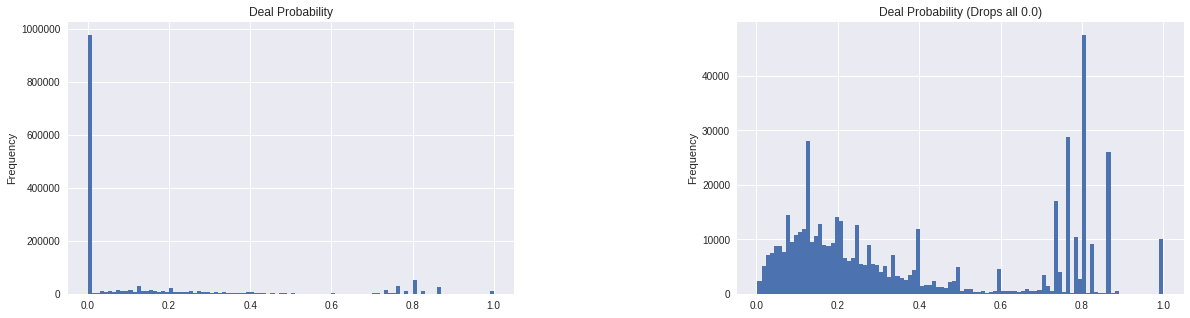

In [7]:
# deal_probability
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplots_adjust(wspace=0.5, hspace=0.0);

dfs['train'].deal_probability.plot.hist(bins=100, ax=axes[0], title='Deal Probability')
dfs['train'][dfs['train'].deal_probability > 0].deal_probability.plot.hist(bins=100, ax=axes[1], title='Deal Probability (Drops all 0.0)')

# Uniform sampling (see below) implies that its better for our regressor to generate 4 main category of output
# 0. 0.0
# 1. 0.0 < p < 0.6
# 2. 0.6 <= p < 0.89
# 3. 1.0

# No deals happends at 0.89 <= p < 1.0
sum((dfs['train'].deal_probability >= 0.89) & (dfs['train'].deal_probability < 1)), sum((dfs['train'].deal_probability >= 0.88) & (dfs['train'].deal_probability < 1))

# TODO:
# deal_probability to categorial label 0~4, model predict 5 output: probability of 0~4, if group = 1 or 2, then use the values of 5th output, else output 0 or 1 depends on the category 

In [0]:
# image_top_1
# image_top_1 is very likely image categorical labels
# https://www.kaggle.com/liuhdsgoal/about-image-top-1is-a-classify-label

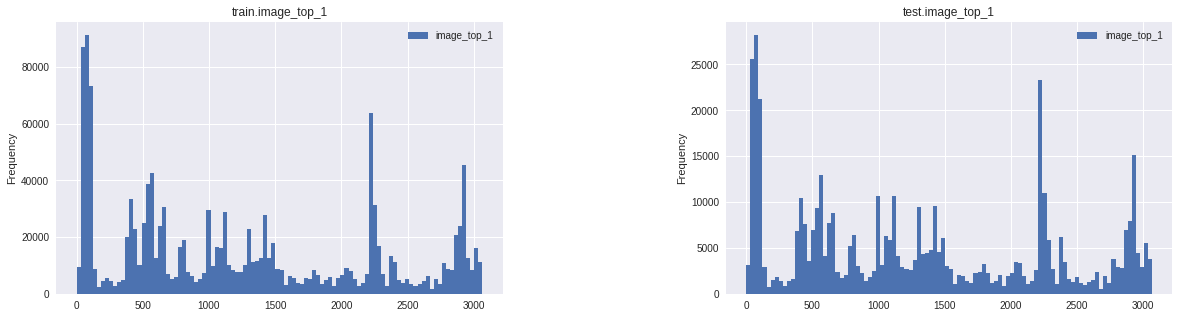

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plt.subplots_adjust(wspace=0.5, hspace=0.0);

dfs['train'].image_top_1.plot.hist(bins=100, ax=axes[0], legend=True, title='train.image_top_1')
dfs['test'].image_top_1.plot.hist(bins=100, ax=axes[1], legend=True, title='test.image_top_1')

In [10]:
# looking at the above distribution, it looks like training and testing is splited by uniform sampling.
# TODO: Fill N/A with 3067, convert to int, do one-hot encoding
max(dfs['train'].image_top_1.max(), dfs['test'].image_top_1.max()), min(dfs['train'].image_top_1.min(), dfs['test'].image_top_1.min())

(3066.0, 0.0)

In [11]:
# region
dfs['train'].region.unique(), dfs['test'].region.unique(), len(dfs['train'].region.unique()), len(dfs['test'].region.unique())

(array(['Свердловская область', 'Самарская область', 'Ростовская область',
        'Татарстан', 'Волгоградская область', 'Нижегородская область',
        'Пермский край', 'Оренбургская область', 'Ханты-Мансийский АО',
        'Тюменская область', 'Башкортостан', 'Краснодарский край',
        'Новосибирская область', 'Омская область', 'Белгородская область',
        'Челябинская область', 'Воронежская область',
        'Кемеровская область', 'Саратовская область',
        'Владимирская область', 'Калининградская область',
        'Красноярский край', 'Ярославская область', 'Удмуртия',
        'Алтайский край', 'Иркутская область', 'Ставропольский край',
        'Тульская область'], dtype=object),
 array(['Волгоградская область', 'Свердловская область',
        'Новосибирская область', 'Саратовская область',
        'Оренбургская область', 'Ростовская область',
        'Калининградская область', 'Пермский край', 'Краснодарский край',
        'Башкортостан', 'Самарская область', 'Иркутска

In [12]:
# city
dfs['train'].city.unique(), dfs['test'].city.unique(), len(dfs['train'].city.unique()), len(dfs['test'].city.unique())

(array(['Екатеринбург', 'Самара', 'Ростов-на-Дону', ..., 'Левокумка',
        'Онохино', 'Ломинцевский'], dtype=object),
 array(['Волгоград', 'Нижняя Тура', 'Бердск', ..., 'Новорождественская',
        'Жигалово', 'Преградное'], dtype=object),
 1733,
 1644)

In [13]:
# category name
dfs['train'].category_name.unique(), dfs['test'].category_name.unique(), len(dfs['train'].category_name.unique()), len(dfs['test'].category_name.unique())

(array(['Товары для детей и игрушки', 'Мебель и интерьер', 'Аудио и видео',
        'Автомобили', 'Ремонт и строительство',
        'Одежда, обувь, аксессуары', 'Детская одежда и обувь', 'Квартиры',
        'Товары для компьютера', 'Собаки', 'Дома, дачи, коттеджи',
        'Товары для животных', 'Другие животные', 'Комнаты',
        'Коллекционирование', 'Коммерческая недвижимость',
        'Посуда и товары для кухни', 'Красота и здоровье', 'Аквариум',
        'Телефоны', 'Часы и украшения', 'Предложение услуг', 'Птицы',
        'Спорт и отдых', 'Музыкальные инструменты', 'Бытовая техника',
        'Игры, приставки и программы', 'Земельные участки',
        'Продукты питания', 'Кошки', 'Билеты и путешествия',
        'Книги и журналы', 'Растения', 'Гаражи и машиноместа',
        'Мотоциклы и мототехника', 'Планшеты и электронные книги',
        'Оборудование для бизнеса', 'Настольные компьютеры', 'Ноутбуки',
        'Велосипеды', 'Грузовики и спецтехника', 'Готовый бизнес',
        'Фо

In [14]:
# user_type
dfs['train'].user_type.unique(), dfs['test'].user_type.unique(), len(dfs['train'].user_type.unique()), len(dfs['test'].user_type.unique())

(array(['Private', 'Company', 'Shop'], dtype=object),
 array(['Private', 'Shop', 'Company'], dtype=object),
 3,
 3)

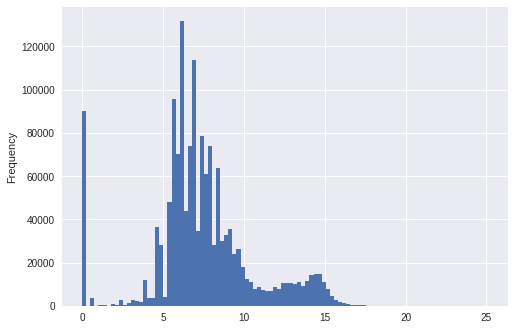

In [15]:
# price
# TODO: log and standardize, append flag for isnan
import numpy as np
np.log(dfs['train'].price.fillna(0.) + 1).plot.hist(bins=100)

In [16]:
# param_1,2,3
dfs['test']['param_1'].unique(), dfs['test']['param_2'].unique(), dfs['test']['param_3'].unique()

(array(['Для мальчиков', 'Дорожные', 'Телевизоры и проекторы', 'Для кухни',
        'Детские коляски', 'Окна и балконы', nan, 'Аксессуары',
        'Флэшки и карты памяти', 'Для девочек', 'Уход за животными',
        'Стройматериалы', 'Ремонт, строительство', 'Мужская одежда',
        'С/х животные', 'Книги', 'Часы', 'Транспорт, перевозки',
        'Женская одежда', 'Климатическое оборудование', 'Канцелярия',
        'Шкафы и комоды', 'Развлечения', 'Видеокамеры', 'С пробегом',
        'Путешествия', 'Продам', 'Столы и стулья', 'Сетевое оборудование',
        'МФУ, копиры и сканеры', 'Другое', 'Инструменты', 'Кролики',
        'Предметы интерьера, искусство', 'Музыкальные центры, магнитолы',
        'Другая', 'Аккордеоны, гармони, баяны', 'Сниму', 'Samsung',
        'Ремонт и обслуживание техники', 'Сантехника и сауна',
        'Фитнес и тренажёры', 'Сдам', 'Мотоциклы', 'Мониторы',
        'Автомобильные кресла', 'Мастер на час', 'Учебная литература',
        'Игры для приставок', 'Биж

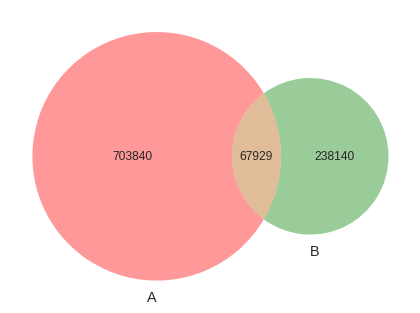

In [17]:
# user_id
dfs['train'].groupby('user_id').size().describe()

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

venn2([set(dfs['train']['user_id']), set(dfs['test']['user_id'])])
plt.show()

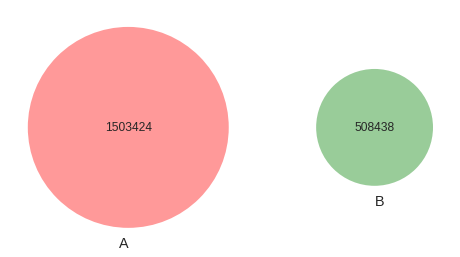

In [18]:
# item_id
venn2([set(dfs['train']['item_id']), set(dfs['test']['item_id'])])
plt.show()

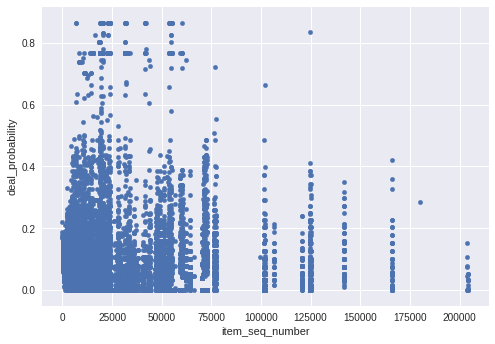

In [11]:
# item_seq_number
dfs['train'][['item_seq_number', 'deal_probability']].groupby('item_seq_number').mean().reset_index().plot.scatter(x='item_seq_number', y='deal_probability')
# look's like long tail category encoding would capture

In [32]:
# just convert to week day and month and day category
pd.to_datetime(dfs['test']['activation_date']).dt.weekday

0         1
1         6
2         0
3         0
4         5
5         2
6         0
7         1
8         1
9         2
10        3
11        3
12        0
13        6
14        1
15        6
16        4
17        3
18        1
19        4
20        3
21        4
22        3
23        3
24        6
25        0
26        4
27        4
28        1
29        3
         ..
508408    0
508409    2
508410    0
508411    0
508412    6
508413    6
508414    4
508415    5
508416    0
508417    4
508418    1
508419    1
508420    5
508421    3
508422    0
508423    4
508424    4
508425    0
508426    4
508427    2
508428    2
508429    4
508430    1
508431    5
508432    2
508433    1
508434    2
508435    4
508436    3
508437    1
Name: activation_date, Length: 508438, dtype: int64